In [58]:
import os
import warnings
import argparse
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

import torch.nn.functional as F
from torch.utils.data import DataLoader
from glob import glob

from scripts.utils import (_get_device,
                        prepare_dataset,
                        _get_dataloaders,
                        get_normalized_mean,
                        get_labelled_indices,
                        sabotage_samples)
from scripts.trainer import Trainer
from scripts.test import evaluate_test_data
from scripts.model import Unet
from config import Config
from scripts.dataset import ThyroidNodules
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
from timeit import default_timer as timer
import os
import numpy as np
import pandas as pd
import torch  # type: ignore
import torch.nn as nn  # type: ignore
import torch.nn.functional as F  # type: ignore

from torch.autograd import Variable  # type: ignore
from timeit import default_timer as timer
from torch.utils.tensorboard import SummaryWriter  # type: ignore

from scripts.utils import prepare_dataset, calculate_metrics,weight_schedule
from scripts.test import evaluate_test_data
from scripts.loss import (compute_loss, DiceLoss,temporal_loss,consistency_loss,
                          pi_model_loss,
                          get_labelled_examples_in_batch)
from scripts.model import Unet
from config import Config

from glob import glob

In [60]:
config = Config()
rng = np.random.RandomState(26)
seeds = rng.randint(10000, size=config.n_exps)
mode = config.mode
RESULTS_DIR = config.RESULTS_DIR
THRESHOLD = config.THRESHOLD
device = _get_device()
os.makedirs(os.path.join(RESULTS_DIR, config.experiment_name), exist_ok=True)
# Initialize the seeds
seed = seeds[0]
# Initialized the object for end to end pipeline
model = Unet(img_ch=3, output_ch=1, batch_size=config.BATCH_SIZE, device=device).to(
    device
)
ssl = Trainer(seed=seed, device=device, model=model, config_file=config)
# Prepare dataset
mean_per_channel, std_per_channel = get_normalized_mean(
    sorted(glob(os.path.join((config.train_x), "*")))
)
train_dataset, test_dataset = prepare_dataset(
    train_x=sorted(glob(os.path.join((config.train_x), "*")))[:],
    train_y=sorted(glob(os.path.join((config.train_y), "*")))[:],
    valid_x=sorted(glob(os.path.join((config.valid_x), "*")))[:],
    valid_y=sorted(glob(os.path.join((config.valid_y), "*")))[:],
    H=config.H,
    W=config.W,
    mean=mean_per_channel,
    std=std_per_channel,
)
labelled_indices = get_labelled_indices(
    train_dataset.images,
    RATIO_LABELLED_SAMPLES=config.RATIO_LABELLED_SAMPLES,
    seed = seed
)
unlabelled_idxs, train_dataset = sabotage_samples(labelled_indices, train_dataset)
assert np.all(np.array(train_dataset.masks)[unlabelled_idxs[0]] == -1)
assert np.all(np.array(train_dataset.masks)[labelled_indices[0]] != -1)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=config.SHUFFLE_TRAIN,
    num_workers=config.NUM_WORKERS,
    drop_last=True,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=config.SHUFFLE_TEST,
    num_workers=config.NUM_WORKERS,
    drop_last=True,
)

Using Apple MPS


In [63]:
print("Sample labelled indices", labelled_indices[6])

Sample labelled indices 502


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


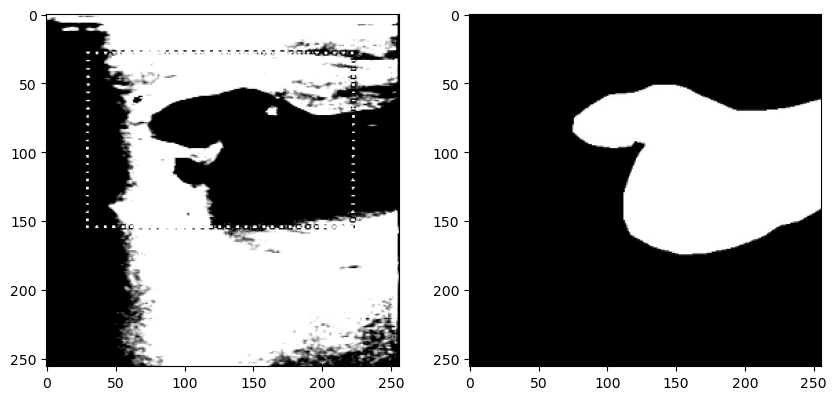

In [66]:
import matplotlib.pyplot as plt
# %matplotlib inline
fig,ax = plt.subplots(1,2,figsize = (10,5))
ax[0].imshow(train_dataset.__getitem__(labelled_indices[6])[0].detach().cpu().numpy().transpose(1, 2, 0),cmap='gray')
ax[1].imshow(train_dataset.__getitem__(labelled_indices[6])[1].detach().cpu().numpy().transpose(1, 2, 0),cmap = 'gray')
plt.show()

In [39]:
# from PIL import Image
# import matplotlib.pyplot as plt
# %matplotlib inline
# def visualize_images_and_masks(x,y,num_images = 2):
#     fig, axs = plt.subplots(num_images, 2, figsize=(5, 5))
#     for i in range(num_images):
#         axs[i, 0].imshow(np.transpose(x[i].cpu().numpy(), (1, 2, 0)),cmap='gray')
#         axs[i, 0].set_title("Image {}".format(i + 1))
#         axs[i, 1].imshow(y[i].squeeze().cpu().numpy())
#         axs[i, 1].set_title("Mask {}".format(i + 1))
#         axs[i,0].set_xticks([])
#         axs[i,0].set_yticks([])
#         axs[i,1].set_xticks([])
#         axs[i,1].set_yticks([])
#     # for i in range(3):
#     plt.tight_layout()
#     plt.xticks([])
#     plt.show()

In [40]:
# sample_indices = list(unlabelled_idxs)[0:3]
# input_image = np.array(train_dataset.images)[sample_indices]
# # input_image = np.swapaxes(input_image,axis1 =  1,axis2 = 3)
# label = np.array(train_dataset.masks)[sample_indices]
# # torch.from_numpy(input_image).shape,torch.from_numpy(label).shape
# input_image = torch.from_numpy(input_image).to(device)
# label = torch.from_numpy(label).to(device)
# input_image = input_image.permute(0, 3,1,2)
# label = label.unsqueeze(1)
# arr1 = np.zeros((3,1,256,256)).astype(np.float32)
# arr2 = np.zeros((3,3,256,256)).astype(np.float32)
# tensor1 = torch.from_numpy(arr1).to(ssl.device)
# tensor2 = torch.from_numpy(arr2).to(ssl.device)
# input_image = torch.concatenate(tensors=(input_image,tensor2))
# label  = torch.concatenate(tensors=(tensor1,label))
# # label.shape
# # input_image.shape,label.shape
# model.eval()
# predicted_masks = model(input_image)
# total_loss, supervised_loss, unsup_loss,nbsup = pi_model_loss(
#     actual_mask=label,
#     pred_mask=predicted_masks,
#     ensemble_mask = label,
#     weight= torch.tensor([0.4],requires_grad=True).to(device),
#     device=device
# )
# print(f" Total loss: {total_loss.item()} \n Supervised loss: {supervised_loss.item()} \n Unsupervised loss: {unsup_loss.item()} \n Number of supervised examples: {nbsup}")

Define Temporal Loss
1. Supervised Loss : if label is not -1 then compute cross entropy and dice loss
2. Unsupervised Loss : Calcualte the mean squared error loss between the two images i.e output from model and previous epochs averaged output (32,1,256,256)

In [41]:
writer = ssl.writer
# setup param optimization
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=ssl.config.LR,
    betas=(0.9, 0.99)
)
ntrain = len(train_dataset)
n_samples = ssl.config.n_samples

In [42]:
# train
model.train()
losses = []
sup_losses = []
unsup_losses = []
best_loss = 20.0
Z = (
    torch.zeros(ntrain, 1, ssl.config.H, ssl.config.W).float().to(ssl.device)
)  # intermediate values
z = (
    torch.zeros(ntrain, 1, ssl.config.H, ssl.config.W).float().to(ssl.device)
)  # intermediate values
outputs = (
    torch.zeros(ntrain, 1, ssl.config.H, ssl.config.W).float().to(ssl.device)
)  # intermediate values

for epoch in range(1):
    t = timer()
    # evaluate unsupervised cost weight
    w = weight_schedule(
        epoch,
        ssl.config.max_epochs,
        ssl.config.max_val,
        ssl.config.ramp_up_mult,
        ssl.config.k,
        ssl.config.n_samples,
    )
    if (epoch + 1) % 10 == 0:
        print("unsupervised loss weight : {}".format(w))
    # iterate over all batches
    # turn it into a usable pytorch object
    w = torch.autograd.Variable(torch.FloatTensor([w]), requires_grad=False).to(
        ssl.device
    )
    l = []
    supl = []
    unsupl = []
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images).to(ssl.device)
        labels = Variable(labels, requires_grad=False).to(ssl.device)
        # get output and calculate loss
        optimizer.zero_grad()
        out = model(images)
        # Store the outputs in the tensor
        # (batch_size,1,H,W)
        z_comp = Variable(
            z[i * ssl.config.BATCH_SIZE : (i + 1) * ssl.config.BATCH_SIZE],
            requires_grad=False,
        ).to(ssl.device)
        # compute temporal loss
        loss, sup_loss, unsup_loss, nbsup = pi_model_loss(
            actual_mask=labels,
            pred_mask=out,
            ensemble_mask=z_comp,
            weight=w,
            device=ssl.device,
        )
        # save the output and losses
        outputs[i * ssl.config.BATCH_SIZE : (i + 1) * ssl.config.BATCH_SIZE] = (
            out.data.clone()
        )
        # backprop
        loss.backward()
        # update weights
        optimizer.step()
        # print loss
        i = int(i)
        epoch = int(epoch)
        l.append(loss.item())
    # All batches have been trained
    # Update the mean ensemble of outputs
    Z = (ssl.config.alpha * Z) + (
        1.0 - ssl.config.alpha
    ) * outputs  # outputs + Smoothed version of Outputs
    z = Z * (1.0 / (1.0 - ssl.config.alpha ** (epoch + 1)))
    # print loss
    # losses.append(np.mean(batch_losses))
    # saving model
    if np.mean(l) < best_loss:
        best_loss = np.mean(l)
        torch.save({"state_dict": model.state_dict()}, ssl.model_save_path)

    # if (epoch + 1) % 10 == 0:
    if True:
        print(
            "Epoch [%d/%d], Training Loss: %.6f, Time (this epoch): %.2f s"
            % (
                epoch + 1,
                ssl.config.NUM_EPOCHS,
                np.mean(l),
                timer() - t,
            )
        )
    # handle metrics, losses, etc.
    eloss = np.mean(l)
    losses.append(eloss)
    sup_losses.append(
        (1.0 / ssl.config.k) * np.sum(supl)
    )  # division by 1/k to obtain the mean supervised loss
    unsup_losses.append(np.mean(unsupl))

    # saving model
    if eloss < best_loss:
        best_loss = eloss
        torch.save({"state_dict": model.state_dict()}, "model_best.pth.tar")
    # Log the losses in the writer
    # Log the loss and accuracy values at the end of each epoch
    writer.add_scalar("Loss/supervised_training_loss", sup_losses[-1], epoch)
    writer.add_scalar("Loss/unsupervised_training_loss", unsup_losses[-1], epoch)
    writer.add_scalar("Loss/training_loss", losses[-1], epoch)

    # test
    # model.eval()
    # acc = calc_metrics(model, ssl.test_loader, device=ssl.device)
    # if self.config.print_res:
    #     print(
    #         "Accuracy of the networ on the 10000 test images: %.2f %%"
    #         % (acc)
    #     )
    # # test best model
    # checkpoint = torch.load("model_best.pth.tar")
    # model.load_state_dict(checkpoint["state_dict"])
    # model.eval()
    # acc_best = calc_metrics(model, self.test_loader, device=self.device)
    # if self.config.print_res:
    #     print(
    #         "Accuracy of the network (best model) on the 10000 test images: %.2f %%"
    #         % (acc_best)
    #     )
# One complete forward and backward pass completes for all samples

AttributeError: 'Config' object has no attribute 'alpha'

In [43]:
# All batches have been trained
# Update the mean ensemble of outputs
ssl.config.alpha = 0.4
Z = (ssl.config.alpha * Z) + (
    1.0 - ssl.config.alpha
) * outputs  # outputs + Smoothed version of Outputs
z = Z * (1.0 / (1.0 - ssl.config.alpha ** (epoch + 1)))
# print loss
# losses.append(np.mean(batch_losses))
# saving model
if np.mean(l) < best_loss:
    best_loss = np.mean(l)
    torch.save({"state_dict": model.state_dict()}, ssl.model_save_path)

# if (epoch + 1) % 10 == 0:
if True:
    print(
        "Epoch [%d/%d], Training Loss: %.6f, Time (this epoch): %.2f s"
        % (
            epoch + 1,
            ssl.config.NUM_EPOCHS,
            np.mean(l),
            timer() - t,
        )
    )
# handle metrics, losses, etc.
eloss = np.mean(l)
losses.append(eloss)
sup_losses.append(
    (1.0 / ssl.config.k) * np.sum(supl)
)  # division by 1/k to obtain the mean supervised loss
unsup_losses.append(np.mean(unsupl))

# saving model
if eloss < best_loss:
    best_loss = eloss
    torch.save({"state_dict": model.state_dict()}, "model_best.pth.tar")
# Log the losses in the writer
# Log the loss and accuracy values at the end of each epoch
writer.add_scalar("Loss/supervised_training_loss", sup_losses[-1], epoch)
writer.add_scalar("Loss/unsupervised_training_loss", unsup_losses[-1], epoch)
writer.add_scalar("Loss/training_loss", losses[-1], epoch)


Epoch [1/10], Training Loss: 0.671562, Time (this epoch): 593.93 s


In [46]:
np.mean(l)

0.6715622617957298

In [ ]:
# Fit the model for each seeds
if mode == "train":
    model, _ = ssl.fit(train_loader=train_loader, test_dataset=test_dataset)
# Test the model
# ssl.device = torch.device("cpu")
try:
    checkpoint = torch.load(
        ssl.model_save_path,
        map_location=ssl.device,
    )
except FileNotFoundError:
    print("Model not found")
    # return pd.DataFrame()
model.load_state_dict(checkpoint["state_dict"])
model.eval()
df = evaluate_test_data(
    model=model,
    torch_dataset=test_dataset,
    torch_device=ssl.device,
    RESULT_DIR=os.path.join(RESULTS_DIR, config.experiment_name),
    THRESHOLD=THRESHOLD,
    save_csv_file=True,
    save_plots=False,
    show_progress=True,
)

# Custom Transformation

In [16]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        # image = image.transpose((2, 0, 1))
        return torch.from_numpy(image)

In [15]:
from torchvision import transforms as tf

In [31]:
dataset = ThyroidNodules(
    image_size=(256, 256),
    images_path=sorted(
        glob(
            os.path.join(
                "/Users/eloise-em/Documents/Haris Ghafoor Archive/Research and Development/RnD/Thyroid Dataset/tn3k/trainval-image",
                "*",
            )
        )
    ),
    masks_path=sorted(
        glob(
            os.path.join(
                "/Users/eloise-em/Documents/Haris Ghafoor Archive/Research and Development/RnD/Thyroid Dataset/tn3k/trainval-mask",
                "*",
            )
        )
    ),
    transform=tf.Compose(
        [
            ToTensor(),  # Convert to tensor
            # tf.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            tf.RandomHorizontalFlip(p=0.1)
        ]
    ),
)
# print(dataset[0].shape)
print("Sample Image Shape", dataset.__getitem__(0)[0].shape)
print("Sample Mask Shape", dataset.__getitem__(0)[1].shape)

Sample Image Shape torch.Size([3, 256, 256])
Sample Mask Shape torch.Size([1, 256, 256])
